<a href="https://colab.research.google.com/github/josegabrielguerrero26/CSE450-machinelearning/blob/main/project3/module04_biking_grading_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prep work:

*   Download team csv predictions file

*   Rename files to team8-module4-predictions.csv where team8 is the name of your team
*   Make sure file is one column and remove any extra columns
*   Make sure the heading is set to "predictions" (without quotes)
*   Upload csv predictions to session storage area.
  *   Click the folder icon, then click the upload icon (paper with an upward arrow)
*   Run the notebook (Runtime -> Run all)






In [25]:
# MODULE 04 - BIKING HOLDOUT GRADING

from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

# READ IN THE CSV FILES
team_dir = Path("./")
teams = team_dir.glob("*-predictions.csv")
team_list = []
for team in teams:
  # print(latent_file)
  team_list.append((str(team).split("-",1)[0],team))

print(team_list)

[('team8', PosixPath('team8-module3-predictions.csv'))]


In [26]:
# READ IN THE HOLDOUT ANSWERS
targets_file = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/biking_holdout_test_mini_answers.csv"
targets = pd.read_csv(targets_file)
targets['actual'] = targets.casual + targets.registered
targets.drop(columns=['casual','registered'],inplace=True)
# targets

In [27]:
# ARE THE STUDENT DATASETS THE CORRECT LENGTH
student_datasets = {}
for (group, file) in team_list:
  ds = pd.read_csv(file)

  if ds.shape != targets.shape:
    print(f"Error group {group} ds had {ds.shape} rows and columns instead of the expected {targets.shape}. It will be excluded.")
  else:
    student_datasets[group] = ds
    print(f"Group {group} added successfully")

Group team8 added successfully


In [28]:
# student_datasets

In [29]:
def recommended_grade(amount):
  '''
  A simple min max scaler to identify a recommended score for the holdout set
  '''
  min_allowed = level_for_bottom_score
  max_allowed = level_for_top_score
  if amount>max_allowed:
    return 100
  elif amount<min_allowed:
    return 0
  else:
    return (amount - min_allowed) / (max_allowed - min_allowed)*100


In [30]:
results_dict = {}

In [31]:
for group, student_ds in student_datasets.items():
  student_dict = {}
  # print(group,cm)
  student_ds.columns=['predictions']
  mse = mean_squared_error(targets, student_ds, squared=False)
  # print("{} - RMSE: {}".format(group, mse))

  student_dict["RMSE"] = mean_squared_error(targets, student_ds, squared=False)
  student_dict["Mean Abs Error"] = mean_absolute_error(targets, student_ds)
  student_dict["Median Abs Error"] = median_absolute_error(targets, student_ds)
  student_dict["R2"] = r2_score(targets, student_ds)

  combined = pd.concat([targets, student_ds], axis=1)
  combined.columns = ["target", "pred"]
  combined["absdiff"] = (combined["target"] - combined["pred"]).abs()
  combined["absdiff_pct"] = combined["absdiff"] / combined["target"]

  shower = pd.DataFrame(student_ds, columns = ['predictions'])
  shower.columns = ['predictions']
  testfinal = pd.concat([shower,targets['actual']],axis=1)
  testfinal['difference'] = testfinal['actual']-testfinal['predictions']
  testfinal['percent_difference'] = abs(testfinal['difference']/testfinal['actual'])
  testfinal['percent_bucket'] = [ "above 20%" if i >= 0.2 else "below 20%" for i in testfinal.percent_difference ]

  # testfinal

  student_dict['dataset'] = testfinal
  percents = [5, 10, 20]
  for percent in percents:
    student_dict[f"Percent of bikes within {percent} percent"] = len(combined[combined["absdiff_pct"] <= (percent /100)]) / len(combined) * 100

  results_dict[group] = student_dict

In [32]:
# results_dict

In [33]:
results_df = pd.DataFrame(results_dict)
results_ds_trans = results_df.transpose()
results_ds_trans = results_ds_trans.drop(columns=["dataset"])

results_ds_trans = results_ds_trans.round(2)
results_ds_trans = results_ds_trans.sort_values(by="R2",ascending=False)


In [34]:
# results_df

-------------------------------- TEAM8 RESULTS ---------------------------------

 Within 5%: 1.8229166666666667%
 Within 10%: 4.427083333333334%
 Within 20%: 8.854166666666668%
 R^2: -0.4616621150142537%
 RMSE: 440.1449501621237
 Mean Absolute Error: 322.1353419010416
 Median Aboslute Error: 168.5


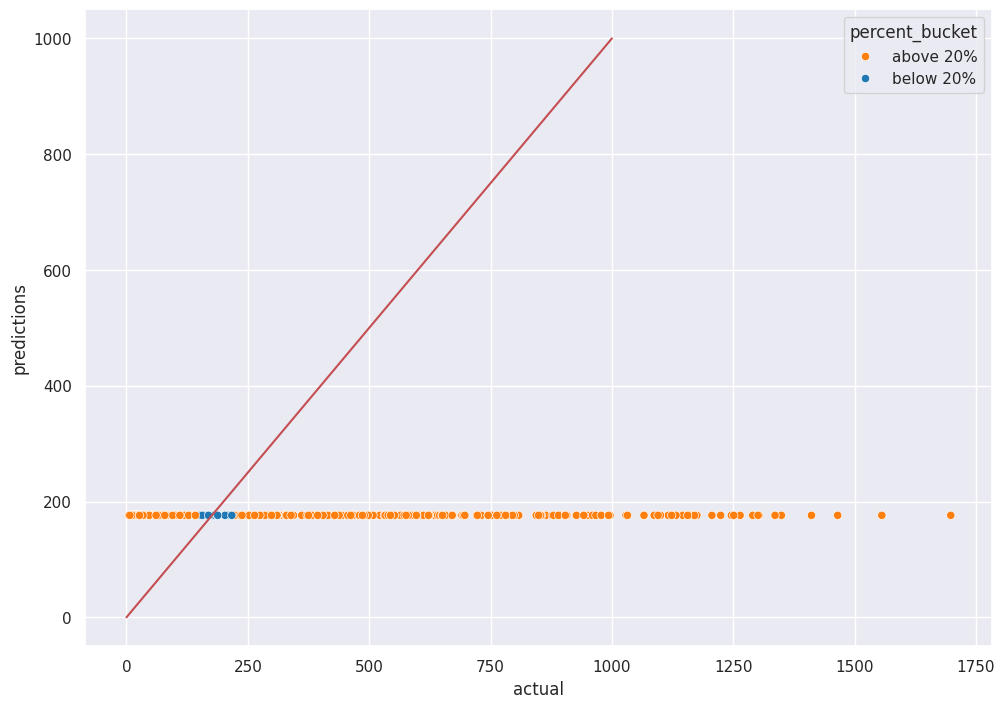

-----------------------------------------------------------------------------






In [35]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
for team_results in results_dict.items():
  testfinal = team_results[1]['dataset']
  # print(team_results['dataset'])
  # print(f"R-Squared Value: {r2}")
  print(f"-------------------------------- {team_results[0].upper()} RESULTS ---------------------------------\n")
  print(f" Within 5%: {team_results[1]['Percent of bikes within 5 percent']}%\n",
  f"Within 10%: {team_results[1]['Percent of bikes within 10 percent']}%\n",
  f"Within 20%: {team_results[1]['Percent of bikes within 20 percent']}%\n",
  f"R^2: {team_results[1]['R2']}%\n",
  f"RMSE: {team_results[1]['RMSE']}\n",
  f"Mean Absolute Error: {team_results[1]['Mean Abs Error']}\n",
  f"Median Aboslute Error: {team_results[1]['Median Abs Error']}")


  color_dict = dict({'below 20%':'tab:blue',
                    'above 20%': 'tab:orange'})
  # print(testfinal['abspercentmiss'].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9,.95]))
  xlims=(0,1e3)
  # ylims=(0,1e3)
  ax = sns.scatterplot(data=testfinal,x='actual',y='predictions',hue="percent_bucket",palette=color_dict)
  # ax.set(xscale="log", yscale="log", xlim=xlims, ylim=ylims)
  ax.plot(xlims,xlims, color='r')
  # plt.legend(labels=['perfect',"below 5",'above 5','10-20%','above 20'])
  plt.show()
  print(f"-"*77)
  print("\n"*3)


-------------------------------- TEAM8 RESULTS ---------------------------------



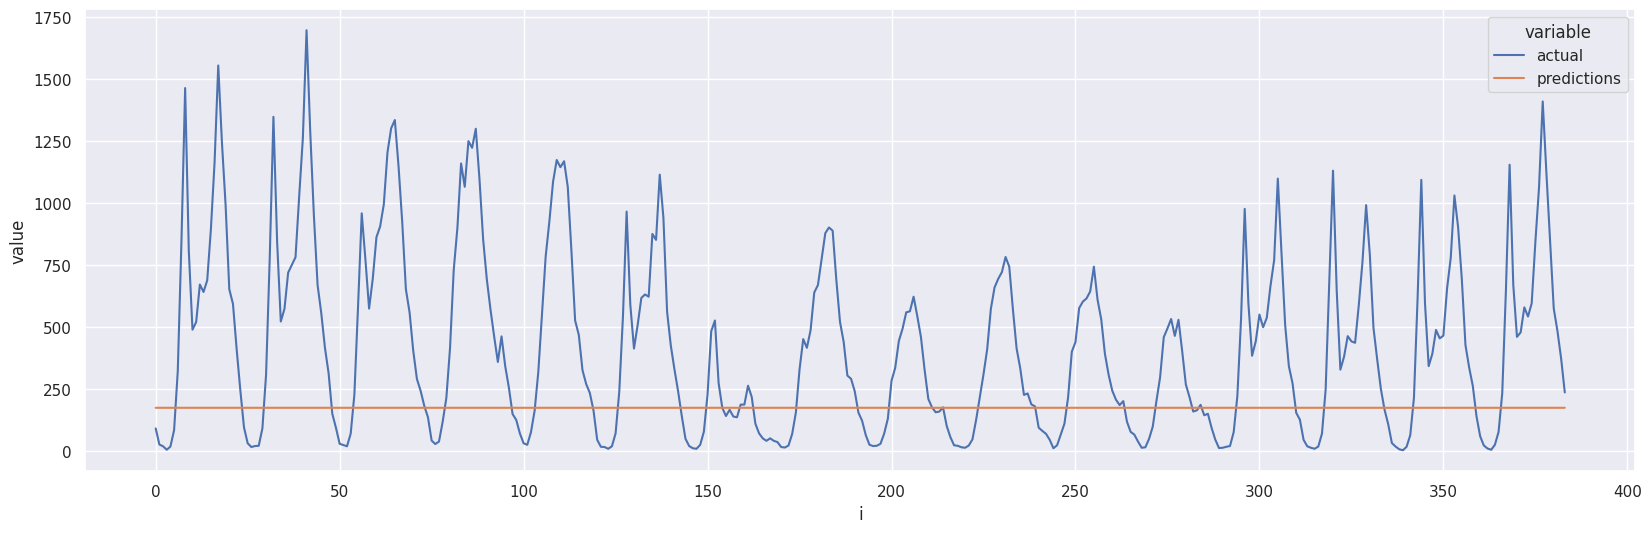

-----------------------------------------------------------------------------






In [36]:
pd.set_option('mode.chained_assignment',None)
sns.set(rc={'figure.figsize':(20,6)})
for team_results in results_dict.items():
  print(f"-------------------------------- {team_results[0].upper()} RESULTS ---------------------------------\n")
  testfinal = team_results[1]['dataset']
  testfinal = testfinal[['actual', 'predictions']]
  testfinal['i'] = testfinal.index
  testfinal=testfinal.melt(['i'])

  ax = sns.lineplot(data=testfinal,x='i',y='value',hue='variable')

  plt.show()
  print(f"-"*77)
  print("\n"*3)